# Percettrone

## Dataset

Generiamo un dataset giocattolo per sperimentare con un classificatore percettrone

In [59]:
import pandas as pd
import numpy as np


def generate_dataset(n, dim, threshold=0.75):
    # Generate n points in dim-dimensional space // Matrix of random numbers
    points = np.random.rand(n, dim)

    # Create a DataFrame from the matrix of points
    df = pd.DataFrame(points)

    # Assign column names [x0..xDim]
    df.columns = ['x{}'.format(i) for i in range(dim)]

	# Set the target column depending on the sum of all the values in a certain row
    # - If the sum of all the attributes is below the threshold (0.75) then 0 otherwise 1
    df["label"] = np.where(df.sum(axis="columns") < threshold, 0, 1)

    return df

In [60]:
# Generate the dataframe using the function above
df = generate_dataset(1000, 2, 0.75)

In [61]:
# Print dataframe row to check the values / target label is correct
print(df.loc[[3]])

         x0        x1  label
3  0.060291  0.136207      0


## Dataset exploration

In [66]:
df.head(30)

,x0,x1,label
0,0.674058,0.167451,1
1,0.899565,0.770164,1
2,0.034796,0.952098,1
3,0.060291,0.136207,0
4,0.742614,0.490700,1
5,0.307215,0.303216,0
6,0.186762,0.770303,1
7,0.190425,0.194758,0
8,0.781358,0.817650,1
9,0.773180,0.889061,1


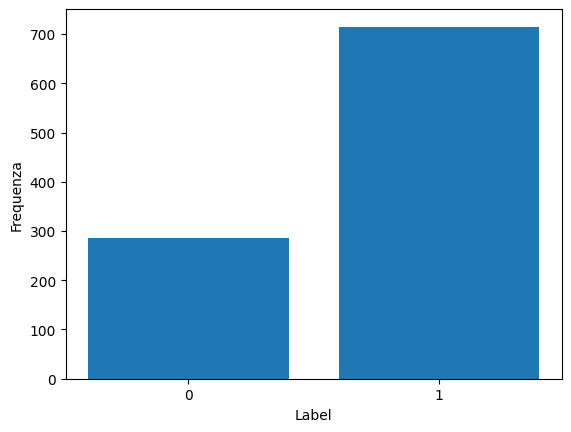

In [63]:
import matplotlib.pyplot as plt

# Unique label values on the X axis, Value counts on the Y axis
plt.bar(df["label"].unique(), df["label"].value_counts())
plt.ylabel("Frequenza")
plt.xlabel("Label")
plt.xticks([0, 1])
plt.show()

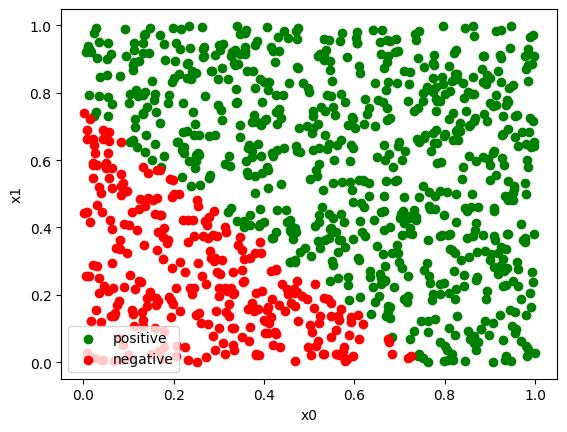

In [64]:
# dividiamo il DataFrame in due sotto-DataFrame in base alla label
df_pos = df[df['label'] == 1]
df_neg = df[df['label'] == 0]

# plot degli scatter plot per i due sotto-DataFrame
fig, ax = plt.subplots()
ax.scatter(df_pos['x0'], df_pos['x1'], c='green', label='positive')
ax.scatter(df_neg['x0'], df_neg['x1'], c='red', label='negative')

ax.legend()
ax.set_xlabel('x0')
ax.set_ylabel('x1')

plt.show()

In questo laboratorio dovrai **implementare il percettrone (tradizionale)** e il **percettrone (delta rule)**, seguendo questo pseudocodice:
<br><br>

**def** funzione(data, threshold) {

1. Initialize the weights: w0=-threshold, w1,w2 random

2. Set a control variable for convergence

3. Check convergency: all instances should be correctly classified.

   3. a. Adjust weights for misclassified instances

4. return weights

}

In [87]:
from pandas import DataFrame

def perceptron(data: DataFrame, threshold: float):
    input = data[['x0', 'x1']]
    target = data['label'].to_numpy()

    # Learning rate
    rate = 0.2

    # initialize bias weight
    w0 = -threshold

    # initialize weights
    w = np.random.rand(input.columns.size)

    # Control Variables
    converged = False
    tcount = 0

    while (not converged and tcount < 4000):
        converged = True
        for instance in range(len(input.index)):
            sum = w0

            # compute perceptron output
            for i in range(input.ndim):
                sum += input.values[instance][i] * w[i]

            perc_out = 0 if sum < 0 else 1


            #if actual output is different from expected output -> update weights with the perceptron rule
            if (target[instance] != perc_out):
                converged = False
                #print("w: {}".format(w))
                w0 = w0 + rate*(target[instance]-perc_out)*1
                for i in range(input.ndim):
                    #print("comp: targets {}-{}, input:{}".format(perc_out, target[instance], input.values[instance][i]))
                    w[i] = w[i] + rate*(target[instance]-perc_out)*input.values[instance][i]
        tcount += 1

    if (converged):
        print("CONVERGED!")
    elif (tcount >= 4000):
        print("FUCKING DEAD")

    return [w0, *w]

perceptron(df, 0.75)

CONVERGED!


[np.float64(-0.95),
 np.float64(1.2639485235176522),
 np.float64(1.2763807571343078)]

In [51]:
%%capture
test = df[['x0', 'x1']]

len(test.index)